# HOGP 教程:
作者：  <br />
日期: 2023-12-1    <br />

大多数高斯过程（GP）工作侧重于学习单个输出函数，但许多应用，如物理模拟和基因表达预测，需要对具有许多输出的函数进行估计。HOGP相对于普通的GP，其实现更加的复杂，在输入和潜在特征上使用具有Kronecker乘积结构，使其能对数百万个输出进行精确推理，更容易拓展到高维空间。

背景知识：<br />
1.Kronecker积的定义<br />
一般而言，给定任意矩阵$ \mathcal{X} \in \mathcal{R}^{m \times n} $和$\mathcal{Y} \in \mathcal{R}^{p \times q}$，则矩阵$\mathcal{X}$ 和矩阵 $\mathcal{Y}$ 的Kronecker积为<br />
$$(\mathcal{X} \otimes \mathcal{Y})_{(i \cdot p) + k, (j \cdot q) + l} = \mathcal{X}_{i, j} \cdot \mathcal{Y}_{k, l}$$
2.Tucker运算<br />
张量分解（tensor decomposition）是一种将一个高阶张量表示为多个低秩张量乘积的方法。Tucker分解是其中一种常用的张量分解方法，它将一个张量分解为一个核张量（core tensor）与一组因子矩阵（factor matrices）。Tucker运算指的是使用Tucker分解来进行张量的乘法和重构。


HOGP可以处理多维数据，在这篇教程中，为了介绍HOGP，我们从一个简单的例子开始，即在给定输入$\mathcal{x}$的情况下预测图像的像素值(两个像素越接近，它们的相关性就越强)，即二维输出$y \in \mathcal{R}^{d_1 \times d_2}$。相对应的
$\mathcal{x} \in \mathcal{R}^D$，输入的是一个D维的向量。<br />
那么让我们开始吧～ 由于这篇应用是基于Torch开发的，所以我们将从导入Torch库作为开端。

In [1]:
import torch
import torch.nn as nn
# from torch.autograd import Variable

torch.manual_seed(1)       #set seed for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(device)


1.12.0+cpu
cpu


#### 1. 加载训练数据
我们为本教程准备了256组图像数据$x,y$，存放在data_sample中，其中128组用于训练$xtr,ytr$，128组用于测试$xte,yte$。在训练前，我们将数据组织成tensor，并对数据进行归一化处理，HOGP可以处理多维数据，因此我们还需要在定义HOGP时获取输出维度。

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.load('data_sample/input.npy')
x = torch.tensor(x, dtype=torch.float32).to(device)
y = np.load('data_sample/output_fidelity_2.npy')
y = torch.tensor(y, dtype=torch.float32).to(device)

from utils.normalizer import Dateset_normalize_manager
dnm = Dateset_normalize_manager([x], [y])

#train_set
xtr = [x[:128,:]]
ytr = [y[:128,:]]
#test_set
xte = [x[128:,:]]
yte = [y[128:,:]]
output_shape=ytr[0][0,...].shape
xtr, ytr = dnm.normalize_all(xtr, ytr)
xte=dnm.normalize_inputs(xte)
#plot the data
print("xtr.size:", xtr[0].size(), "ytr.size:", ytr[0].size())
print("xte.size:", xte[0].size(), "yte.size:", yte[0].size())



xtr.size: torch.Size([128, 5]) ytr.size: torch.Size([128, 100, 100])
xte.size: torch.Size([128, 5]) yte.size: torch.Size([128, 100, 100])


#### 2. 核函数以及模型参数（超参数）

HOGP使用到核函数，我们需要优化的函数是：均值函数以及核函数。但是优化一个“函数”并不是就想所说的那么简单， 因此我们需要给定这些函数的特定形式，之后再去优化他们的参数。在这篇教程中，我们设定均值函数为零（不需要优化均值函数）。而核函数部分，我们使用最常用的automatic relevance determinant（ARD）核函数：
$$k_{ard}(\mathbf{x}, \mathbf{x}') = a \cdot \exp(-\frac{1}{2} \sum_{d=1}^D{ (\frac{x_d-x'_d}{l_d}})^2 )$$
其中$a$是核函数的振幅，$l_d$是输入变量$x$的d维输入${x}_d$的长度系数（length scale）。$\mathbf{l}$ 控制着每个输入维度的贡献量，比如：$l_d$数值越大，则${x}_d$相比于其他维度在系统中的贡献越大；反之亦然。因此，这个函数被称为ARD，即可以自动控制相关性。 <br />

那么现在我们可以定义核函数了，其返回值为输入两组数据的一个核矩阵。

In [3]:
EPS = 1e-9
class ARDKernel(nn.Module):
    def __init__(self, input_dim, initial_length_scale=1.0, initial_signal_variance=1.0, eps=EPS):
        super(ARDKernel, self).__init__()
        # Initialize length scales for each dimension
        self.length_scales = nn.Parameter(torch.ones(input_dim) * initial_length_scale)
        self.signal_variance = nn.Parameter(torch.tensor([initial_signal_variance]))
        self.eps = eps  # Small constant to prevent division by zero

    def forward(self, x1, x2):
        
        # Ensure length scales are positive and add a small constant for numerical stability
        length_scales = torch.abs(self.length_scales) + self.eps

        # Compute scaled squared Euclidean distances
        scaled_x1 = x1 / length_scales
        scaled_x2 = x2 / length_scales
        sqdist = torch.cdist(scaled_x1, scaled_x2, p=2)**2
        return self.signal_variance.abs() * torch.exp(-0.5 * sqdist)

kernel = ARDKernel(1).to(device)
kernel_matrix = kernel(xtr[0], xtr[0])
print(kernel_matrix)
print("kernel_matrix size:",kernel_matrix.shape)

tensor([[1.0000e+00, 5.6946e-04, 1.9744e-05,  ..., 9.2815e-05, 4.4355e-04,
         1.9422e-05],
        [5.6946e-04, 1.0000e+00, 1.5448e-01,  ..., 5.0722e-02, 5.4402e-02,
         4.7291e-02],
        [1.9744e-05, 1.5448e-01, 1.0000e+00,  ..., 3.3030e-03, 1.6783e-03,
         6.5005e-03],
        ...,
        [9.2815e-05, 5.0722e-02, 3.3030e-03,  ..., 1.0000e+00, 3.9196e-04,
         3.9196e-04],
        [4.4355e-04, 5.4402e-02, 1.6783e-03,  ..., 3.9196e-04, 1.0000e+00,
         5.6946e-04],
        [1.9422e-05, 4.7291e-02, 6.5005e-03,  ..., 3.9196e-04, 5.6946e-04,
         1.0000e+00]], grad_fn=<MulBackward0>)
kernel_matrix size: torch.Size([128, 128])


#### 3. HOGP_simple
回到我们这个例子。一般来说，函数输出并不表示图像像素；HOGP没有明确的坐标来索引输出并反映它们的相关性。为了解决这个问题，HOGP将所有输出重新排列到多维空间（即张量空间）中，并引入潜在的坐标特征来索引输出并捕捉它们的相关性(self.grid),输入与潜在特征的映射用mapping_vector表示。最后，我们将输入和潜在特征相结合，为重新排列的输出建立GP回归模型。具体来说，给定训练数据集D，我们可以使用Q+1模张量$Z∈R^{d_1×··×d_Q ×N}$来表示N个训练输入的所有观测输出。训练数据可以表示为$(X,Z)$,将潜在特征向量堆叠成Q个矩阵，$V＝${$V^1,...,V^Q$}.HOGP结合了原始输入$X$和潜在坐标特征$V$，通过多线性Tucker算子生成所有输出。以$V^1$为例，用映射的特征向量$φ（v^1_j）$来替换$V^1$中的每一行$v^1_j$。用$φ(V^1)$表示映射的特征矩阵。用核矩阵$K^1$替换$φ(V^1)φ(V^1)^T$，其中每个元素$[K^1]_{i,j} = k_1(v^1_i , v^1_j )$是一个执行隐式特征映射和内积的核函数,我们得到：
$$p(Z|X, V, τ ) = N (vec(Z)|0, K^1 ⊗ ... ⊗ K^Q ⊗ K + τ^{-1}I)$$
其中{$K^1,...,K^Q$}是输入X的潜在坐标特征{$V^1,...,V^Q$}的核矩阵，$K$是输入$X$的核矩阵，以我们的例子为例，我们的HOGP就需要有2+1个核函数<br />
下面给出HOGP_simple_demo的初始化实现

In [4]:
class HOGP_simple_demo(nn.Module):
    def __init__(self,noise_variance,output_shape,learnable_grid=False,learnable_map=False):
        super().__init__()
        self.noise_variance = nn.Parameter(torch.tensor([noise_variance]))
        self.kernel_list = []
        self.K = []
        self.K_eigen = []
        self.kernel_list = nn.ModuleList()
        for _ in range(len(output_shape) + 1):
            new_kernel = kernel.ARDKernel(1)
            self.kernel_list.append(new_kernel)
        self.grid = nn.ParameterList()
        for _value in output_shape:
            self.grid.append(nn.Parameter(torch.tensor(range(_value)).reshape(-1, 1).float()))
        if learnable_grid is False:
            for i in range(len(self.grid)):
                self.grid[i].requires_grad = False
        self.mapping_vector = nn.ParameterList()
        for _value in output_shape:
            self.mapping_vector.append(nn.Parameter(torch.eye(_value)))
        if learnable_map is False:
            for i in range(len(self.mapping_vector)):
                self.mapping_vector[i].requires_grad = False

#### 4.对数似然函数（log likelihood）
HOGP是GP和潜在GP模型的混合——每个输出$y_c$与观察到的输入向量$x$和$Q$个潜在坐标特征向量{$v^1_{c_1},...,v^K_{c_K}$}相关联。因此，给定观测数据集$D$=（$X，Z$），推理需要估计$Q$模式张量空间中的所有潜在特征，$V$={$V^1,...,V^Q$}，以及潜在特征和原始输入的核参数，以及逆方差$τ$。<br />
HOGP的对数似然函数为：
$$L = log (p(Z|X, V, τ )) = -\frac{1}{2} log |S| -\frac{1}{2} vec(Z)^TS^{−1}vec(Z) + const$$

其中$S = K^1⊗...⊗K^Q⊗K+τ^{−1}I$,符号 ⊗ 表示Kronecker积
为了更好的计算对数似然函数，首先用其特征分解(求特征值与特征向量)来表示S中的每个核矩阵K，即$K = U^Tdiag(λ)U^T$,经过分解后$$S = U_1diag(λ_1)U1^T ⊗...⊗ U_Qdiag(λ_Q)U^T_Q⊗U^Tdiag(λ)U^T + τ^{-1}I$$
利用Kronecker乘积性质，我们可以得出：$$S = PΛP^T + τ^{−1}I$$
其中$P = U_1 ⊗...⊗ U_Q ⊗ U$ , $Λ = diag(λ_1 ⊗...⊗ λ_Q ⊗ λ)$
由于$U$和每个$U_k（1≤k≤Q）$都是特征向量并且是正交的，所以它们的Kronecker乘积也是正交的.<br />
进一步可以得到:
$$S = P(Λ + τ^{-1}I)P^T, S^{-1} = P(Λ + τ^{-1}I)^{−1}P^T$$
因此：
$log |S| = log |P(Λ + τ^{-1}I)P^T| = log |P^TP(Λ+τ^{-1}I)| = log |Λ+τ^{-1}|$<br />
对于对数似然函数的第二块：
$$vec(Z)^TS^{−1}vec(Z) = b^Tb$$
$$b = S^{-\frac{1}{2}}vec(Z) = P(Λ + τ^{−1})^{-\frac{1}{2}}P^T · vec(Z)$$
由于$P$是Kronecker乘积，我们可以递归地应用Tucker算子的性质来计算$b$<br />
$$T_1 = Z ×_1 U^T_1 ... ×_Q U^T_Q ×_{Q+1}U^T$$
$$T_2 = T_1 \bigodot A^{•-\frac{1}{2}}$$
$$T_3 = T_2 ×_1 U_1...×_QU_Q×_{Q+1}U $$
$\bigodot$表示元素乘积，$(·)•^{-\frac{1}{2}}$是对元素取二分之一的幂，$A^{•-\frac{1}{2}}$对应$(Λ + τ^-1I)^{-\frac{1}{2}}$的对角线<br />
接下来，我们一起把前向的过程用代码编写出来；注意，此处的前向过程还涉及到了$g$的计算，$g$主要用于预测使用，$g$的含义会在下一节解释~


In [5]:
import math
import tensorly
from tensorly import tucker_to_tensor
tensorly.set_backend('pytorch')
class eigen_pairs:
    def __init__(self, matrix) -> None:
        eigen_value, eigen_vector = torch.linalg.eigh(matrix, UPLO='U')
        self.value = eigen_value
        self.vector = eigen_vector
def log_likelihood_demo(self, x_train,y_train):
        
        # for param_name, param in self.named_parameters():
        #     print(f"{param_name}: {param}")

        self.K.clear()
        self.K_eigen.clear()
        self.K.append(self.kernel_list[0](x_train[0], x_train[0]))
        self.K_eigen.append(eigen_pairs(self.K[-1]))

        for i in range(0, len(self.kernel_list)-1):
            _in = tensorly.tenalg.mode_dot(self.grid[i], self.mapping_vector[i], 0)
            self.K.append(self.kernel_list[i+1](_in, _in))
            self.K_eigen.append(eigen_pairs(self.K[-1]))
        _init_value = torch.tensor([1.0],  device=list(self.parameters())[0].device).reshape(*[1 for i in self.K])
        lambda_list = [eigen.value.reshape(-1, 1) for eigen in self.K_eigen]
        A = tucker_to_tensor((_init_value, lambda_list))
        A = A + self.noise_variance.pow(2)* tensorly.ones(A.shape,  device=list(self.parameters())[0].device)

        T_1 = tensorly.tenalg.multi_mode_dot(y_train[0], [eigen.vector.T for eigen in self.K_eigen])
        T_2 = T_1 * A.pow(-1/2) 
        T_3 = tensorly.tenalg.multi_mode_dot(T_2, [eigen.vector for eigen in self.K_eigen]) 
        b = tensorly.tensor_to_vec(T_3)
        g = tensorly.tenalg.multi_mode_dot(T_1 * A.pow(-1), [eigen.vector for eigen in self.K_eigen]) 

        self.b = b
        self.A = A
        self.g= g
        nd = torch.prod(torch.tensor([value for value in self.A.shape]))
        loss = -1/2* nd * torch.log(torch.tensor(2 * math.pi, device=list(self.parameters())[0].device))
        loss += -1/2* torch.log(self.A).sum()
        loss += -1/2* self.b.t() @ self.b

        loss = -loss/nd
        return loss

#### 5. 预测（Predict）
给定一个新的输入$x^*$,通过条件高斯分布计算d个输出的预测分布，张量化为$y^*$，即：
$$p(Y^*|x^*, D) = N (vec(Y^*)|μ^*, Σ^*) $$
预测的均值为：<br />
$$μ^* = (K^1 ⊗ ...⊗ K^Q ⊗ k_*)g $$
其中：$g = S^{−1}vec(Z)$
$$Σ^* = (K^1 ⊗ ... ⊗ K^Q)k(x^*, x^*) − (K^1 ⊗ ...⊗ K^Q ⊗ k_*)S^{−1}(K^1 ⊗ ... ⊗ K^Q ⊗ k^T_*)$$
$$k_* = [k(x^*, x_1),..., k(x^*, x_N )]$$
有关均值的计算，我们可以使用Tucker运算进行有效计算，另外对于$Σ^*$的计算，可以使用上面提到的核矩阵特征分解的方法进行计算，可以得出：
$$Σ^* = (K^1 ⊗...⊗ K^Q)k(x^*, x^*) − LL^T$$
其中$L = (U_1 ⊗...⊗ U_Q ⊗ k_*K^{−1}U)(Λ(Λ + τ^{−1}I)-\frac{1}{2})$<br />
所有预测的方差为：
$$diag(Σ^*) = k(x^*, x^*)diag(K_1 ⊗...⊗ K^Q) − diag(LL^T) = k(x^*, x^*)diag(K^1 ⊗ ...⊗ K^Q) − L^{•2} ·1$$
最后我们使用张量代数计算预测的方差：
$$diag(Σ^*) = vec(M)$$
$$M = k(x^*, x^*)·(diag(K^1)◦...◦diag(K^Q))+S^{•2}×_1U^{•2}_1...×_QU^{•2}_Q ×_{Q+1}(k_* K^{−1} U)^{•2}$$
其中$◦$为Kruskal算子<br />
预测过程的代码如下：


In [6]:
def forward_demo(self,x_train,x_test):
    with torch.no_grad():
        
        K_star = self.kernel_list[0](x_test[0], x_train[0])
        K_predict = [K_star] + self.K[1:]

        predict_u = tensorly.tenalg.multi_mode_dot(self.g, K_predict)
        n_dim = len(self.K_eigen) - 1
        _init_value = torch.tensor([1.0]).reshape(*[1 for i in range(n_dim)]).to(x_train[0].device)
        diag_K_dims = tucker_to_tensor(( _init_value, [K.diag().reshape(-1,1) for K in self.K[1:]]))
        diag_K_dims = diag_K_dims.unsqueeze(0)
        diag_K_x = self.kernel_list[0](x_test[0], x_test[0]).diag()
        for i in range(n_dim):
            diag_K_x = diag_K_x.unsqueeze(-1)
        diag_K = diag_K_x*diag_K_dims

        S = self.A * self.A.pow(-1/2)
        S_2 = S.pow(2)
        eigen_vectors_x = K_star@self.K[0]
        eigen_vectors_dims = [self.K_eigen[i+1].vector.pow(2) for i in range(n_dim)]
        
        eigen_vectors = [eigen_vectors_x] + eigen_vectors_dims
        S_product = tensorly.tenalg.multi_mode_dot(S_2, eigen_vectors)
        var_diag = diag_K + S_product
    
    return predict_u, var_diag

#### 6.完整HOGP_simple定义
分别了解了HOGP各个模块以及参数后，下面我们给出完整的HOGP_simple定义，并进行实例化

In [7]:
class HOGP_simple(nn.Module):
    def __init__(self,noise_variance,output_shape,learnable_grid=False,learnable_map=False):
        super().__init__()
        self.noise_variance = nn.Parameter(torch.tensor([noise_variance]))
        self.kernel_list = []
        self.K = []
        self.K_eigen = []
        self.kernel_list = nn.ModuleList()
        for _ in range(len(output_shape) + 1):
            new_kernel = ARDKernel(1)
            self.kernel_list.append(new_kernel)
        self.grid = nn.ParameterList()
        for _value in output_shape:
            self.grid.append(nn.Parameter(torch.tensor(range(_value)).reshape(-1, 1).float()))
        if learnable_grid is False:
            for i in range(len(self.grid)):
                self.grid[i].requires_grad = False
        self.mapping_vector = nn.ParameterList()
        for _value in output_shape:
            self.mapping_vector.append(nn.Parameter(torch.eye(_value)))
        if learnable_map is False:
            for i in range(len(self.mapping_vector)):
                self.mapping_vector[i].requires_grad = False

        
    def forward(self,x_train,x_test):
        with torch.no_grad():
            
            K_star = self.kernel_list[0](x_test[0], x_train[0])
            K_predict = [K_star] + self.K[1:]

            predict_u = tensorly.tenalg.multi_mode_dot(self.g, K_predict)
            n_dim = len(self.K_eigen) - 1
            _init_value = torch.tensor([1.0]).reshape(*[1 for i in range(n_dim)]).to(x_train[0].device)
            diag_K_dims = tucker_to_tensor(( _init_value, [K.diag().reshape(-1,1) for K in self.K[1:]]))
            diag_K_dims = diag_K_dims.unsqueeze(0)
            diag_K_x = self.kernel_list[0](x_test[0], x_test[0]).diag()
            for i in range(n_dim):
                diag_K_x = diag_K_x.unsqueeze(-1)
            diag_K = diag_K_x*diag_K_dims

            S = self.A * self.A.pow(-1/2)
            S_2 = S.pow(2)
            eigen_vectors_x = K_star@self.K[0]
            eigen_vectors_dims = [self.K_eigen[i+1].vector.pow(2) for i in range(n_dim)]
            
            eigen_vectors = [eigen_vectors_x] + eigen_vectors_dims
            S_product = tensorly.tenalg.multi_mode_dot(S_2, eigen_vectors)
            var_diag = diag_K + S_product
        
        return predict_u, var_diag
    
    def log_likelihood(self, x_train,y_train):
        
        self.K.clear()
        self.K_eigen.clear()
        self.K.append(self.kernel_list[0](x_train[0], x_train[0]))
        self.K_eigen.append(eigen_pairs(self.K[-1]))

        for i in range(0, len(self.kernel_list)-1):
            _in = tensorly.tenalg.mode_dot(self.grid[i], self.mapping_vector[i], 0)
            self.K.append(self.kernel_list[i+1](_in, _in))
            self.K_eigen.append(eigen_pairs(self.K[-1]))
        _init_value = torch.tensor([1.0],  device=list(self.parameters())[0].device).reshape(*[1 for i in self.K])
        lambda_list = [eigen.value.reshape(-1, 1) for eigen in self.K_eigen]
        A = tucker_to_tensor((_init_value, lambda_list))
        A = A + self.noise_variance.pow(-1)* tensorly.ones(A.shape,  device=list(self.parameters())[0].device)

        T_1 = tensorly.tenalg.multi_mode_dot(y_train[0], [eigen.vector.T for eigen in self.K_eigen])
        T_2 = T_1 * A.pow(-1/2) 
        T_3 = tensorly.tenalg.multi_mode_dot(T_2, [eigen.vector for eigen in self.K_eigen]) 
        b = tensorly.tensor_to_vec(T_3)
        g = tensorly.tenalg.multi_mode_dot(T_1 * A.pow(-1), [eigen.vector for eigen in self.K_eigen]) 

        self.b = b
        self.A = A
        self.g= g
        nd = torch.prod(torch.tensor([value for value in self.A.shape]))
        loss = -1/2* nd * torch.log(torch.tensor(2 * math.pi, device=list(self.parameters())[0].device))
        loss += -1/2* torch.log(self.A).sum()
        loss += -1/2* self.b.t() @ self.b

        loss = -loss/nd
        return loss
    
    def to(self, *args, **kwargs):
        model = super().to(*args, **kwargs)
        for kernel in model.kernel_list:
            for param_name, param in kernel.named_parameters():
                param.to(*args, **kwargs)
        return model

GPmodel=HOGP_simple(noise_variance=1.0,output_shape=output_shape)
GPmodel.to(device)

HOGP_simple(
  (kernel_list): ModuleList(
    (0): ARDKernel()
    (1): ARDKernel()
    (2): ARDKernel()
  )
  (grid): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 100x1]
      (1): Parameter containing: [torch.FloatTensor of size 100x1]
  )
  (mapping_vector): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 100x100]
      (1): Parameter containing: [torch.FloatTensor of size 100x100]
  )
)

#### 7. 调用优化器并进行训练
当损失函数，也就是对数似然函数定义好之后，我们可以很简单地通过调用优化器来最小化损失函数值并进行训练~

In [8]:
optimizer = torch.optim.Adam(GPmodel.parameters(), lr=1e-2)
for i in range(300):
        optimizer.zero_grad()
        loss = GPmodel.log_likelihood(xtr, ytr)
        loss.backward()
        optimizer.step()
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))

iter 0 nll:1.16044
iter 1 nll:1.14997
iter 2 nll:1.13964
iter 3 nll:1.12948
iter 4 nll:1.11949
iter 5 nll:1.10966
iter 6 nll:1.10001
iter 7 nll:1.09053
iter 8 nll:1.08120
iter 9 nll:1.07206
iter 10 nll:1.06309
iter 11 nll:1.05428
iter 12 nll:1.04565
iter 13 nll:1.03718
iter 14 nll:1.02889
iter 15 nll:1.02076
iter 16 nll:1.01280
iter 17 nll:1.00501
iter 18 nll:0.99737
iter 19 nll:0.98990
iter 20 nll:0.98259
iter 21 nll:0.97544
iter 22 nll:0.96844
iter 23 nll:0.96159
iter 24 nll:0.95490
iter 25 nll:0.94835
iter 26 nll:0.94195
iter 27 nll:0.93569
iter 28 nll:0.92956
iter 29 nll:0.92357
iter 30 nll:0.91772
iter 31 nll:0.91199
iter 32 nll:0.90639
iter 33 nll:0.90092
iter 34 nll:0.89555
iter 35 nll:0.89031
iter 36 nll:0.88518
iter 37 nll:0.88016
iter 38 nll:0.87523
iter 39 nll:0.87042
iter 40 nll:0.86569
iter 41 nll:0.86106
iter 42 nll:0.85652
iter 43 nll:0.85206
iter 44 nll:0.84769
iter 45 nll:0.84339
iter 46 nll:0.83916
iter 47 nll:0.83501
iter 48 nll:0.83092
iter 49 nll:0.82690
iter 50 nl

#### 8. 预测与可视化
训练完HOGP后，我们使用$xte$进行预测，并将结果进行可视化，通过比较GroundTruth与预测值，以及他们的差值，我们可以看到HOGP的预测效果，这里只展示其中的一个预测结果，其余的可以自行尝试~

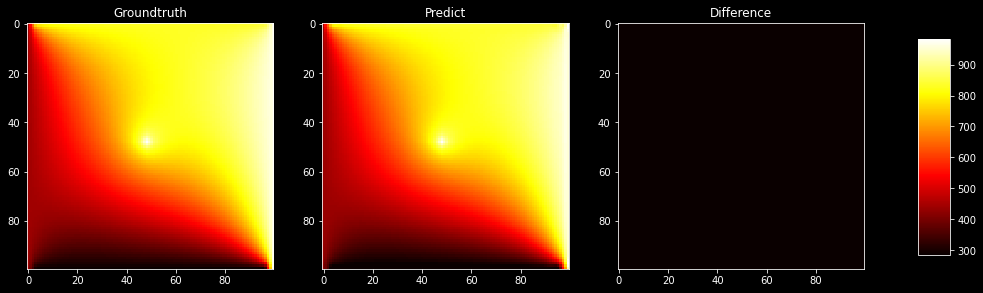

In [9]:
with torch.no_grad():
    ypred, ypred_var = GPmodel.forward(xtr,xte)
    ypred=dnm._denormalize(ypred,'output',0)
    
##plot_res
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
vmin=torch.min(yte[0][1])
vmax=torch.max(yte[0][1])

im=axs[0].imshow(yte[0][1].cpu(), cmap='hot', interpolation='nearest',vmin=vmin,vmax=vmax)
axs[0].set_title('Groundtruth')

axs[1].imshow(ypred[1].cpu(), cmap='hot', interpolation='nearest',vmin=vmin,vmax=vmax)
axs[1].set_title('Predict')

axs[2].imshow((yte[0][1].cpu()-ypred[1].cpu()).abs(), cmap='hot', interpolation='nearest',vmin=vmin,vmax=vmax)
axs[2].set_title('Difference')

cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
cbar=fig.colorbar(im, cax=cbar_ax)
plt.show()